In [1]:
import scipy.io as sio
import scipy
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as op
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import os
import torchvision.transforms as tt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as Fun
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
import random

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_input = []
train_answer = []
test_input = []
test_answer = []
val_input = []
val_answer = []
for SIR in range(0,11):
    data= sio.loadmat('/home2/LIG/BPSK_LFM_Overlap_data/sir_'+str(SIR)+'_dB.mat')
    overlap = data['overlap_stft']
    radar = data['lfm_stft']
    train_overlap = overlap[0:250]
    val_overlap = overlap[250:280]
    test_overlap = overlap[280:300]
    train_radar = radar[0:250]
    val_radar = radar[250:280]
    test_radar = radar[280:300]
    
    train_input.append(train_overlap)
    train_answer.append(train_radar)
    
    test_input.append(test_overlap)
    test_answer.append(test_radar)

    val_input.append(val_overlap)
    val_answer.append(val_radar)


/home/siho0201/anaconda3/envs/dl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cv2
def otsu_thresholding(images):
    # 결과를 저장할 빈 배열을 생성합니다.
    binary_images = np.zeros_like(images)

    for idx, image in enumerate(images):
        image = image.astype(np.uint8)
        _, binary_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # 결과를 binary_images 배열에 저장합니다.
        binary_images[idx] = binary_img

    return binary_images

def normalize(images):
    nor_images = np.zeros_like(images)
    for idx, image in enumerate(images):
        # 이미지의 픽셀 값 범위를 0 ~ 255로 변환합니다.
        min_val = image.min()
        max_val = image.max()
        img = (image - min_val) / (max_val - min_val) *255
        nor_images[idx] = img

    return nor_images


train_input = np.array(train_input)
train_answer = np.array(train_answer)
val_input = np.array(val_input)
val_answer = np.array(val_answer)
test_input = np.array(test_input)
test_answer = np.array(test_answer)

X_train = train_input.reshape(250*11,128,256)
y_train = train_answer.reshape(250*11,128,256)
X_val = val_input.reshape(30*11,128,256)
y_val = val_answer.reshape(30*11,128,256)
X_test = test_input.reshape(20*11,128,256)
y_test = test_answer.reshape(20*11,128,256)

X_train =np.abs(X_train)
y_train =np.abs(y_train)
X_val =np.abs(X_val)
y_val =np.abs(y_val)
X_test =np.abs(X_test)
y_test =np.abs(y_test)

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)
y_train = normalize(y_train)
y_val = normalize(y_val)
y_test = normalize(y_test)

y_train = otsu_thresholding(y_train)
y_val = otsu_thresholding(y_val)
y_test = otsu_thresholding(y_test)

X_train = X_train.reshape(250*11,1,128,256)
y_train = y_train.reshape(250*11,1,128,256)
X_val = X_val.reshape(30*11,1,128,256)
y_val = y_val.reshape(30*11,1,128,256)
X_test = X_test.reshape(20*11,1,128,256)
y_test = y_test.reshape(20*11,1,128,256)

(2750, 1, 128, 256)
(2750, 1, 128, 256)


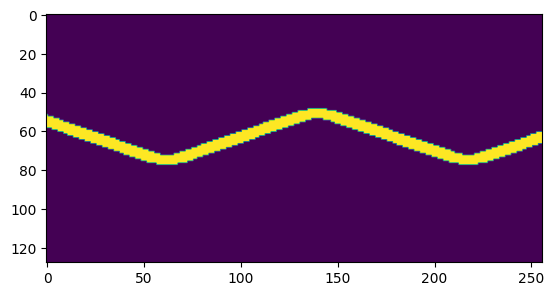

In [3]:
print(X_train.shape)
print(y_train.shape)
sample = y_train[1][0]
plt.imshow(sample)

In [4]:
class Train_data(Dataset): 
  def __init__(self):
    self.x_data = X_train
    self.y_data = y_train
   
    # self.y_data = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]

 
  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = self.x_data[idx].astype(np.float32)
    y = self.y_data[idx].astype(np.float32)
    x = x/255
    y = y/255

    x = torch.tensor(x,dtype = torch.float32)
    y = torch.tensor(y,dtype = torch.float32)
    # x = Fun.normalize(x,p=2,dim=1)
    # y = Fun.normalize(y,p=2,dim=1)
    # print(x)
    # print(y)
    # y = Fun.one_hot(y,num_classes =4)
    return x, y

class val_data(Dataset): 
  def __init__(self):
    self.x_data = X_val
    self.y_data = y_val
   
    # self.y_data = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]

 
  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = self.x_data[idx].astype(np.float32)
    y = self.y_data[idx].astype(np.float32)
    x = x/255
    y = y/255


    x = torch.tensor(x,dtype = torch.float32)
    y = torch.tensor(y,dtype = torch.float32)
    # x = Fun.normalize(x,p=2,dim=1)
    # y = Fun.normalize(y,p=2,dim=1)
    # print(y)
    # y = Fun.one_hot(y,num_classes =4)
    return x, y

class test_data(Dataset): 
  def __init__(self):
    self.x_data = X_test
    self.y_data = y_test
   
    # self.y_data = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]

 
  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = self.x_data[idx].astype(np.float32)
    y = self.y_data[idx].astype(np.float32)
    x = x/255
    y = y/255


    x = torch.tensor(x,dtype = torch.float32)
    y = torch.tensor(y,dtype = torch.float32)
    # x = Fun.normalize(x,p=2,dim=1)
    # y = Fun.normalize(y,p=2,dim=1)
    # print(y)
    # y = Fun.one_hot(y,num_classes =4)
    return x, y
  
train_dataset = Train_data()
val_dataset = val_data()
test_dataset = test_data()
# transform = transforms.Compose([transforms.Normalize(mean=0.5,std=0.5)])
batch_size =64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
# a = LFM[0].astype(np.float32)
# print(a)
# a = a/255
# print(a)

# x = torch.tensor(a,dtype=torch.float32)
# print(x)

In [5]:
## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
       
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)
        x = torch.sigmoid(x) 

        return x

In [6]:
model = UNet()
# if (DEVICE.type == 'cuda') and (torch.cuda.device_count() > 1):
#     print('Multi GPU activate')
#     model = nn.DataParallel(model, device_ids = list(range(NGPU)))
model.to(DEVICE)
# model.to(DEVICE)
optimizer = op.AdamW(model.parameters(),lr=0.0001)
def saveModel():
    path = "./overlap_u-net_mask.pth"
    torch.save(model.state_dict(),path)
criterion = nn.BCELoss().to(DEVICE)
y_pred = []
y_true = []
min_val_loss = float('inf')
print("----------------------Train start------------------------")
for epoch in range(1,1001):  # Train loop
    Train_loss = 0.0 
    Val_loss = 0.0 
    total = 0 
    Train_loss_arr = []
    # running_loss = 0.0
    for data in trainloader:
        train_inputs, train_labels = data
        # print(train_inputs)
        train_inputs = train_inputs.to(DEVICE) 
        train_labels = train_labels.to(DEVICE) 
        optimizer.zero_grad()
        # print(train_inputs.size())
        # print(train_labels.size())
        outputs = model(train_inputs)
        # print(outputs.size())
        Train_loss = criterion(outputs, train_labels)
        Train_loss.backward()
        optimizer.step()
        Train_loss_arr += [Train_loss.item()]
        # loss
    # Test Loop 
    with torch.no_grad(): 
        model.eval()
        Val_loss_arr = []
        for i, data in enumerate(valloader, 0): 
            test_inputs, test_labels = data 
            test_inputs = test_inputs.to(DEVICE) 
            test_labels = test_labels.to(DEVICE) 
            predicted_outputs = model(test_inputs) 
            val_loss = criterion(predicted_outputs, test_labels)
            Val_loss_arr += [val_loss.item()] 
        # 현재 검증 데이터셋의 평균 손실을 계산합니다.
        avg_val_loss = sum(Val_loss_arr) / len(Val_loss_arr)
        
        # 최소 검증 손실을 업데이트하고 모델을 저장합니다.
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            saveModel()
            print('saved best model with validation loss:', min_val_loss)
            

    print("----------------------End Train------------------------")
    print("EPOCH %04d | Train loss %.4f | Valid loss %.4f" %
                  (epoch, np.mean(Train_loss_arr),np.mean(Val_loss_arr)))


----------------------Train start------------------------
saved best model with validation loss: 0.4131692945957184
----------------------End Train------------------------
EPOCH 0001 | Train loss 0.4180 | Valid loss 0.4132
saved best model with validation loss: 0.022761284994582336
----------------------End Train------------------------
EPOCH 0002 | Train loss 0.0652 | Valid loss 0.0228
saved best model with validation loss: 0.013730352589239677
----------------------End Train------------------------
EPOCH 0003 | Train loss 0.0174 | Valid loss 0.0137
saved best model with validation loss: 0.01221288259451588
----------------------End Train------------------------
EPOCH 0004 | Train loss 0.0125 | Valid loss 0.0122
saved best model with validation loss: 0.008639822481200099
----------------------End Train------------------------
EPOCH 0005 | Train loss 0.0097 | Valid loss 0.0086
saved best model with validation loss: 0.00807810015976429
----------------------End Train--------------------

In [7]:
torch.cuda.empty_cache()
model = UNet()
model.load_state_dict(torch.load('overlap_u-net_mask.pth'))
model.eval()
model.to(DEVICE)

inputs_arr = []
labels_arr = []
pred_arr = []
with torch.no_grad(): 
    for i, data in enumerate(testloader, 0): 
        test_inputs, test_labels = data 
        test_inputs = test_inputs.to(DEVICE) 
        test_labels = test_labels.to(DEVICE) 
        predicted_outputs = model(test_inputs) 
        inputs_arr.append(test_inputs)
        labels_arr.append(test_labels)
        pred_arr.append(predicted_outputs)



In [8]:
import scipy.io

pred_arr_cpu = [pred_arr[i].cpu().numpy() for i in range(len(pred_arr))]
pred_arr_np = np.concatenate(pred_arr_cpu, axis=0)
pred_arr_np = np.squeeze(pred_arr_np)
# pred_label = otsu_thresholding(pred_arr_np)
# print(pred_label.shape)
scipy.io.savemat('pred_label_mask.mat', {'pred_mask': pred_arr_np})

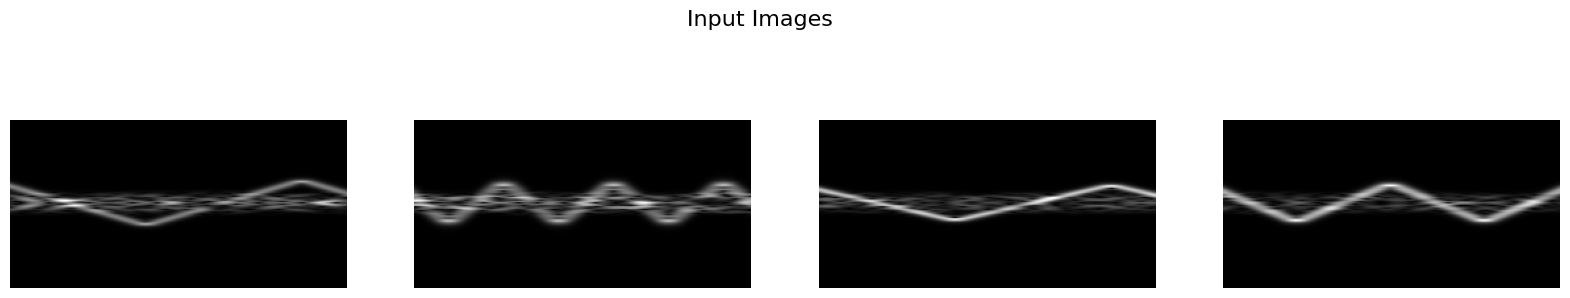

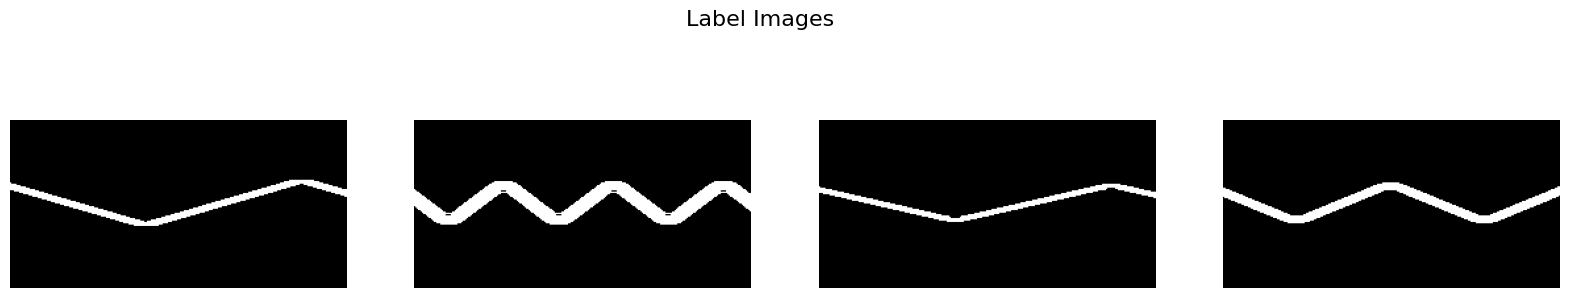

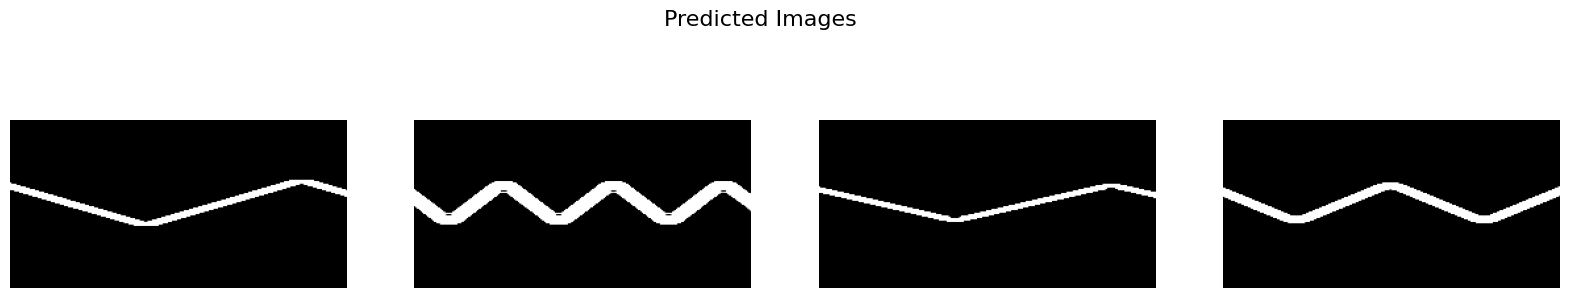

: 

In [9]:
def plot_images(images, title):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)
    for i, img in enumerate(images, 1):
        plt.subplot(1, len(images), i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

# 첫 번째 미니 배치에서 이미지를 선택합니다.
sample_idx = 4  # 원하는 이미지 인덱스를 선택하세요.

input_images = [inputs_arr[i][sample_idx].cpu().numpy().squeeze() for i in range(len(inputs_arr))]
label_images = [labels_arr[i][sample_idx].cpu().numpy().squeeze() for i in range(len(labels_arr))]
pred_images = [pred_arr[i][sample_idx].cpu().numpy().squeeze() for i in range(len(pred_arr))]

# 각각의 이미지를 플롯합니다.
plot_images(input_images, 'Input Images')
plot_images(label_images, 'Label Images')
plot_images(pred_images, 'Predicted Images')
plt.show()